In [1]:
import math

import matplotlib as mpl
from matplotlib import cm
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{libertine}', r'\usepackage{newtxmath}'] 
mpl.rc('font', family='serif')

import numpy as np
import pandas as pd
import seaborn as sns
import copy

import matplotlib.pyplot as plt
from matplotlib import rc

from cycler import cycler

from scipy.interpolate import make_interp_spline, BSpline

mpl.rcParams['ps.usedistiller'] = 'xpdf' 

plt.style.use('seaborn-notebook')

plt.rcParams['axes.titlesize'] = '25'
plt.rcParams['axes.labelsize'] = '25'
plt.rcParams['legend.fontsize'] = '15'
plt.rcParams['xtick.labelsize'] = '18'
plt.rcParams['ytick.labelsize'] = '18'

monochrome=(cycler('color', sns.color_palette("husl", 8))*2+(cycler('marker', ['v', 's', "o"])*7)[0:16])
plt.rc('axes', prop_cycle=monochrome)

pd.options.display.max_rows = 999
pd.options.display.max_columns = None
cmap = cm.get_cmap('RdBu')

husl4 = sns.color_palette("husl", 4)
husl5 = sns.color_palette("husl", 5)
husl6 = sns.color_palette("husl", 7)
greens5 = sns.color_palette("Greens_r", 5)
purples5 = sns.color_palette("Purples_r", 7)
blues5 = sns.color_palette("Blues_r", 5)
reds5 = sns.color_palette("Reds_r", 8)
oranges5 = sns.color_palette("Oranges_r", 5)
greys5 = sns.color_palette("Greys_r", 5)
winter5 = sns.color_palette("viridis_r", 5)

In [2]:
# Note: In the current implement, summary_real and summary_synth are merged, replace the folders accordingly

In [3]:
summary_real = pd.read_csv("../experiments/2020-04-24-23-56_SGMRDsearchers_real_/SGMRDsearchers_real.csv", dtype={"searched": "str"})
summary_real["successpercent"] = [x/y if y>0 else None for x,y in zip(summary_real["success"],summary_real["ntried"])]

In [4]:
summary_synth = pd.read_csv("../experiments/2020-04-24-10-04_SGMRDsearchers_synth_/SGMRDsearchers_synth.csv", dtype={"searched": "str"})
summary_synth["successpercent"] = [x/y if y>0 else None for x,y in zip(summary_synth["success"],summary_synth["ntried"])]

In [5]:
summary_pyro = pd.read_csv("../experiments/2020-04-24-09-40_SGMRDsearchers_pi_/SGMRDsearchers_pi.csv", dtype={"searched": "str"})
summary_pyro["successpercent"] = [x/y if y>0 else None for x,y in zip(summary_pyro["success"],summary_pyro["ntried"])]

In [6]:
summary_pyro.head()

,refId,refCategory,searcherID,nDim,n,searched,ntried,success,indextime,monitortime,decisiontime,searchtime,nSubspaces,avgSubspaceLength,avgContrast,i,rep,successpercent
0,b_1dx100_s,real,SGMRD-KSP-0.9-Worst-1-1000-5-0-1-1,100,10000,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18...,100,0,460.2254,0.0,0.0,800015.0526,100,3.41,0.9889,0,0,0.0
1,b_1dx100_s,real,SGMRD-KSP-0.9-MPTS-1-0.0-1000-20-0-1-1,100,10000,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18...,100,0,458.0917,0.0,0.0,799549.1636,100,3.40,0.9936,0,0,0.0
2,b_1dx100_s,real,SGMRD-KSP-0.9-MPTS-1-0.0-1000-50-0-1-1,100,10000,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18...,100,0,363.7274,0.0,0.0,801604.1908,100,3.49,0.9926,0,0,0.0
3,b_1dx100_s,real,SGMRD-KSP-0.9-MPTS-1-0.0-1000-5-0-1-1,100,10000,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18...,100,0,372.4079,0.0,0.0,802384.5359,100,3.66,0.9916,0,0,0.0
4,b_1dx100_s,real,SGMRD-KSP-0.9-Worst-1-1000-2-0-1-1,100,10000,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18...,100,0,425.9186,0.0,0.0,803178.3656,100,3.47,0.9884,0,0,0.0


In [7]:
summary_synth["searcherID"].unique()

array(['SGMRD-KSP-0.9-RD-1-1000-1-0-1-1',
       'SGMRD-KSP-0.9-MPTS-1-0.0-1000-1-0-1-1',
       'SGMRD-KSP-0.9-None-1000-1-0-1-1',
       'SGMRD-KSP-0.9-Worst-1-1000-1-0-1-1',
       'SGMRD-KSP-0.9-All-1000-1000-0-1-1'], dtype=object)

# Figure 11

In [8]:
selected_searcher = ['SGMRD-KSP-0.9-MPTS-1-0.0-1000-1-0-1-1',
                     'SGMRD-KSP-0.9-RD-1-1000-1-0-1-1',
                    'SGMRD-KSP-0.9-Worst-1-1000-1-0-1-1', 
                    ]

In [9]:
summary = pd.concat([summary_pyro, summary_synth, summary_real])

In [10]:
selected = summary[[x in selected_searcher for x in summary["searcherID"]]]
selected.groupby(["refId", "searcherID"])["successpercent"].mean()

refId       searcherID                           
activity    SGMRD-KSP-0.9-MPTS-1-0.0-1000-1-0-1-1    0.564929
            SGMRD-KSP-0.9-RD-1-1000-1-0-1-1          0.280512
            SGMRD-KSP-0.9-Worst-1-1000-1-0-1-1       0.026066
b_1dx100_s  SGMRD-KSP-0.9-MPTS-1-0.0-1000-1-0-1-1    0.554716
            SGMRD-KSP-0.9-RD-1-1000-1-0-1-1          0.456505
            SGMRD-KSP-0.9-Worst-1-1000-1-0-1-1       0.404733
example_10  SGMRD-KSP-0.9-MPTS-1-0.0-1000-1-0-1-1    0.250861
            SGMRD-KSP-0.9-RD-1-1000-1-0-1-1          0.202200
            SGMRD-KSP-0.9-Worst-1-1000-1-0-1-1       0.206755
example_20  SGMRD-KSP-0.9-MPTS-1-0.0-1000-1-0-1-1    0.373847
            SGMRD-KSP-0.9-RD-1-1000-1-0-1-1          0.299744
            SGMRD-KSP-0.9-Worst-1-1000-1-0-1-1       0.205311
example_50  SGMRD-KSP-0.9-MPTS-1-0.0-1000-1-0-1-1    0.469614
            SGMRD-KSP-0.9-RD-1-1000-1-0-1-1          0.431619
            SGMRD-KSP-0.9-Worst-1-1000-1-0-1-1       0.204311
kdd99       SGMRD-KS

In [11]:
prettynames = {
    'SGMRD-KSP-0.9-All-1000-1000-0-1-1': "GMD-Batch",
    'SGMRD-KSP-0.9-Worst-1-1000-1-0-1-1': "SGMRD-GD",
    'SGMRD-KSP-0.9-RD-1-1000-1-0-1-1': "SGMRD-RD",
    'SGMRD-KSP-0.9-None-1000-1-0-1-1': "GMD-Init",
    'SGMRD-KSP-0.9-MPTS-1-0.0-1000-1-0-1-1': "SGMRD-TS",
    
    "b_1dx100_s": "Pyro",
    "activity": "Activity",
    "kdd99": "KDD99",
    "example_10": "Synth10",
    "example_20": "Synth20",
    "example_50": "Synth50",
}

styledictionary = {
    "GMD-Batch": {'marker': 'o', 'color': reds5[0], 'linestyle': "--"},
    "SGMRD-GD": {'marker': '^', 'color': blues5[2], 'linestyle': "-"},
    "SGMRD-RD": {'marker': 's', 'color': purples5[1], 'linestyle': "-"},
    "GMD-Init": {'marker': 'D', 'color': greens5[0], 'linestyle': "--"},
    "SGMRD-TS": {'marker': 'X', 'color': oranges5[0], 'linestyle': "-"},
}

In [12]:
selected["searcherID"] = [prettynames[x] for x in selected["searcherID"]]

/home/fouchee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
selected["refId"] = [prettynames[x] for x in selected["refId"]]

/home/fouchee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
%matplotlib notebook
selected.groupby(["refId", "searcherID"])["successpercent"].mean()

refId     searcherID
Activity  SGMRD-GD      0.026066
          SGMRD-RD      0.280512
          SGMRD-TS      0.564929
KDD99     SGMRD-GD      0.248365
          SGMRD-RD      0.407400
          SGMRD-TS      0.571726
Pyro      SGMRD-GD      0.404733
          SGMRD-RD      0.456505
          SGMRD-TS      0.554716
Synth10   SGMRD-GD      0.206755
          SGMRD-RD      0.202200
          SGMRD-TS      0.250861
Synth20   SGMRD-GD      0.205311
          SGMRD-RD      0.299744
          SGMRD-TS      0.373847
Synth50   SGMRD-GD      0.204311
          SGMRD-RD      0.431619
          SGMRD-TS      0.469614
Name: successpercent, dtype: float64

In [15]:
selected["refId"].unique()

array(['Pyro', 'Synth10', 'Synth20', 'Synth50', 'KDD99', 'Activity'], dtype=object)

In [16]:
selected["searcherID"].unique()

array(['SGMRD-RD', 'SGMRD-GD', 'SGMRD-TS'], dtype=object)

In [17]:
data = selected.groupby(["refId", "searcherID"])["successpercent"].mean().reset_index()

In [18]:
a = selected.groupby(["refId", "searcherID"])["successpercent"].mean()

<IPython.core.display.Javascript object>


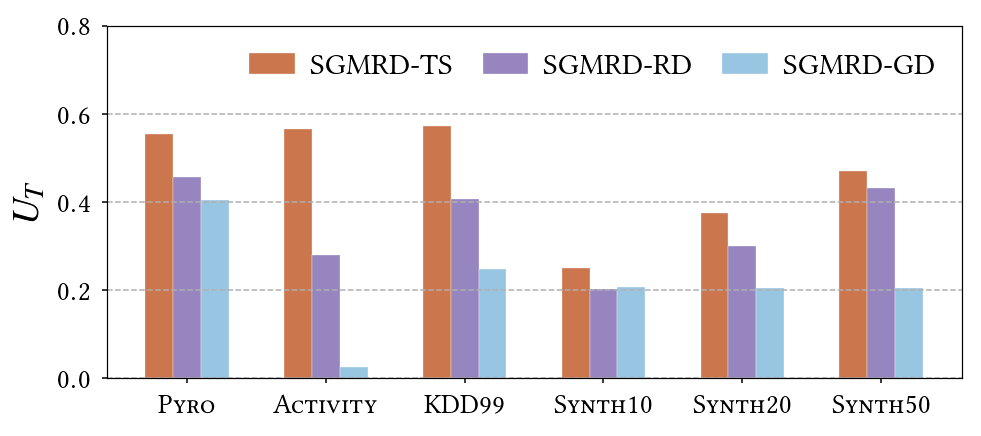

In [19]:
%matplotlib notebook

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,4), sharex=True, sharey="row")

#approach
group1 = ['Pyro', 'Activity', 'KDD99', 'Synth10', 'Synth20', 'Synth50']

#datasets
group2 = ['SGMRD-TS', 'SGMRD-RD', 'SGMRD-GD']
barWidth = 0.2

barss = [] # 
for x in group2: # This gives my custom order
    tmp = []
    subdata = data[data["searcherID"] == x]
    for y in group1:
        tmp = tmp + [subdata[subdata["refId"] == y]["successpercent"].values[0]]
    barss = barss + [tmp]
        

rs = [np.arange(len(barss[0]))]
for x in barss[1::]:
    rs = rs + [[x + barWidth for x in rs[-1]]] 
    
cmap = sns.cubehelix_palette(7, reverse=True)

for i in range(len(barss)):
    plt.bar(rs[i], barss[i], width=barWidth, edgecolor='white', label=r'\textsc{%s}'%group2[i], 
            color=styledictionary[group2[i]]["color"], alpha=0.7)
    
prettygroup = ["KddCup99" if x=="KDD99" else x for x in group1]
prettygroup = ["Pyro" if x=="Bioliq" else x for x in group1]
plt.xticks([r + barWidth*1 for r in range(len(barss[0]))], [r'\textsc{%s}'%x for x in prettygroup])

plt.ylabel("$U_T$")
plt.legend(ncol=3, fontsize=20, columnspacing=1.0, handlelength=1.5, handletextpad=0.5, framealpha=0)


plt.grid(axis="y", linestyle="--")

plt.ylim(0,0.8)

plt.tight_layout()
plt.savefig('plots/Figure11.pdf', bbox_inches = "tight")